In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d aryan401/indian-food-16

 82% 17.0M/20.6M [00:00<00:00, 78.8MB/s]
100% 20.6M/20.6M [00:00<00:00, 84.8MB/s]


In [3]:
import zipfile
zip=zipfile.ZipFile("/content/indian-food-16.zip","r")
zip.extractall('/content')
zip.close()

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.12.0


In [5]:
train_dir=Path("/content/Train")
train_filepaths=list(train_dir.glob(r'**/*.jpg'))

In [6]:
test_dir=Path("/content/Test")
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

In [7]:
val_dir=Path("/content/Validate")
val_filepaths=list(val_dir.glob(r'**/*.jpg'))

In [8]:
import pandas as pd

def image_processing(filepaths):
    # Ensure all filepaths are converted to strings
    filepaths = [str(filepath) for filepath in filepaths]

    # Extract labels from filepaths
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]

    # Create a DataFrame with filepaths and labels
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [9]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)
val_df=image_processing(val_filepaths)

In [10]:
print("---Trainig Set---\n")
print(f"Number of Images: {train_df.shape[0]}\n")
print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

---Trainig Set---

Number of Images: 2982

Number of different labels: 16

Labels: ['Samosas' 'Rasmalai' 'GulabJamun' 'VadaPav' 'Dosa' 'ButterChicken'
 'PaneerTikka' 'Jalebi' 'DalMakhani' 'AlooParatha' 'CholeBhature' 'Naan'
 'Biryani' 'PaniPuri' 'Dhokla' 'Idli']


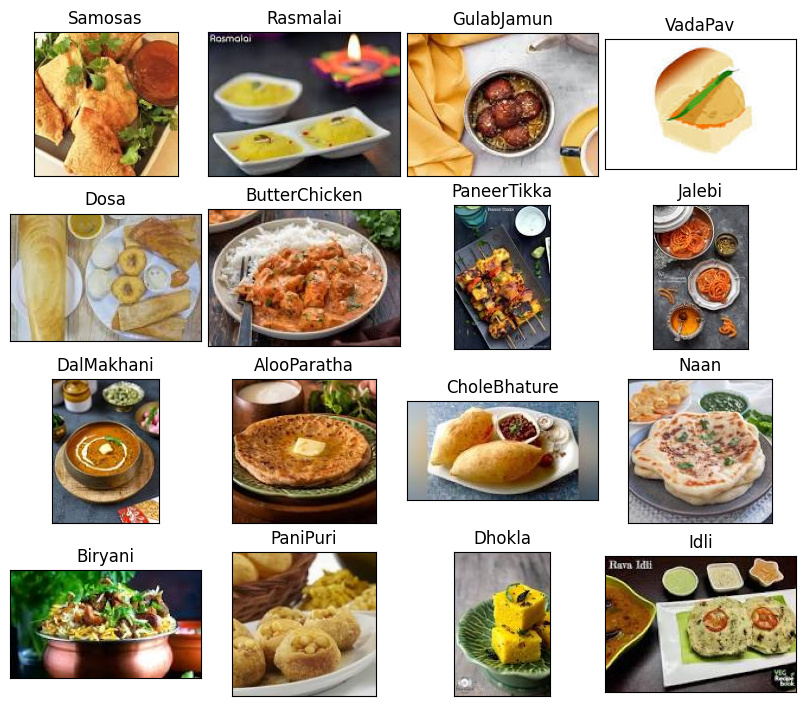

In [11]:
#Create a DataFrame with one label of each category
df_unique=train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

#Displaying Some Images of the dataset
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i],fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [12]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
#Training the image to create a new image and identify(Data Augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 2982 validated image filenames belonging to 16 classes.


In [14]:
#Validating the image to validate a new image and identify
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 442 validated image filenames belonging to 16 classes.


In [15]:
#Testing the image to test a new image and identify
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)


Found 849 validated image filenames belonging to 16 classes.


In [16]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [63]:
from tensorflow.keras.layers import Dropout
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
94/94 [==============================] - 11s 75ms/step - loss: 1.6478 - accuracy: 0.5027 - val_loss: 1.0873 - val_accuracy: 0.6697
Epoch 2/5
94/94 [==============================] - 10s 105ms/step - loss: 0.7580 - accuracy: 0.7693 - val_loss: 0.8475 - val_accuracy: 0.7285
Epoch 3/5
94/94 [==============================] - 12s 125ms/step - loss: 0.5406 - accuracy: 0.8303 - val_loss: 0.8342 - val_accuracy: 0.7262
Epoch 4/5
94/94 [==============================] - 7s 74ms/step - loss: 0.3652 - accuracy: 0.8903 - val_loss: 0.8049 - val_accuracy: 0.7511
Epoch 5/5
94/94 [==============================] - 5s 58ms/step - loss: 0.2637 - accuracy: 0.9232 - val_loss: 0.7549 - val_accuracy: 0.7579


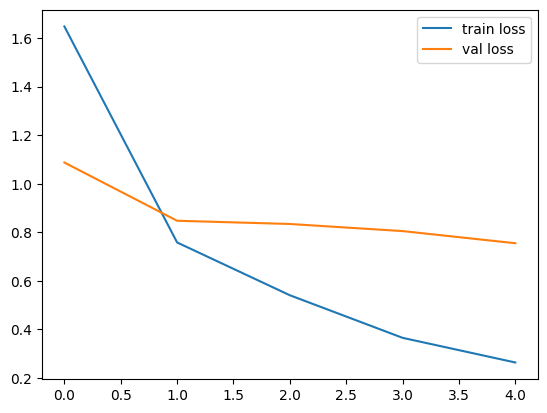

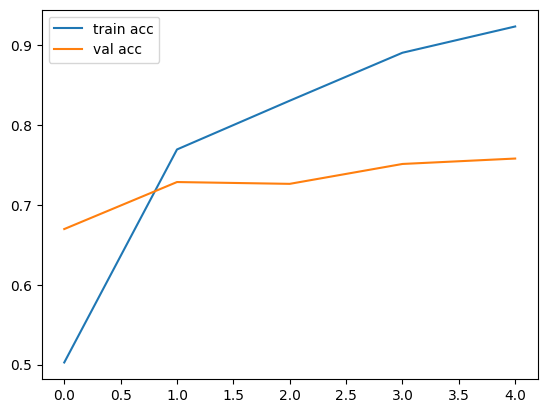

<Figure size 640x480 with 0 Axes>

In [64]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [65]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1


27/27 [==============================] - 2s 52ms/step


['AlooParatha',
 'GulabJamun',
 'PaniPuri',
 'Biryani',
 'ButterChicken',
 'Biryani',
 'Dosa',
 'ButterChicken',
 'Samosas',
 'Samosas',
 'Idli',
 'Samosas',
 'Jalebi',
 'Jalebi',
 'GulabJamun',
 'ButterChicken',
 'Biryani',
 'Idli',
 'ButterChicken',
 'ButterChicken',
 'Biryani',
 'AlooParatha',
 'Dosa',
 'PaniPuri',
 'PaneerTikka',
 'ButterChicken',
 'ButterChicken',
 'DalMakhani',
 'Rasmalai',
 'GulabJamun',
 'Dhokla',
 'Idli',
 'Jalebi',
 'Idli',
 'VadaPav',
 'DalMakhani',
 'Samosas',
 'DalMakhani',
 'Naan',
 'ButterChicken',
 'Dosa',
 'Dosa',
 'PaniPuri',
 'VadaPav',
 'Biryani',
 'VadaPav',
 'VadaPav',
 'Naan',
 'Idli',
 'ButterChicken',
 'Idli',
 'DalMakhani',
 'Dhokla',
 'Idli',
 'Jalebi',
 'Dosa',
 'Idli',
 'Idli',
 'GulabJamun',
 'GulabJamun',
 'Samosas',
 'Dosa',
 'Rasmalai',
 'Idli',
 'PaniPuri',
 'Dosa',
 'Jalebi',
 'VadaPav',
 'Samosas',
 'ButterChicken',
 'VadaPav',
 'AlooParatha',
 'Naan',
 'Samosas',
 'GulabJamun',
 'GulabJamun',
 'ButterChicken',
 'GulabJamun',
 'Dhokl

In [66]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class=answer.argmax(axis=-1)
  y=" ".join(str(x) for x in y_class)
  y=int(y)
  res=labels[y]
  return res

1/1 [==============================] - 0s 25ms/step
Dhokla has approximately  215 calories per serving. 


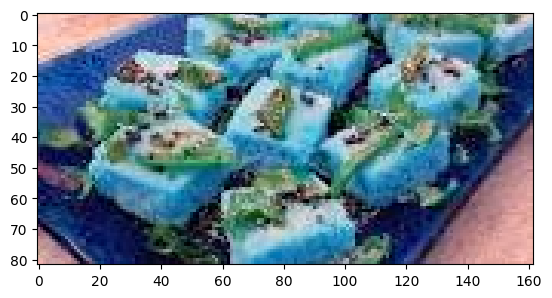

In [82]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2



test_img= cv2.imread("/content/Test/Dhokla/Dhokla103.jpg")
plt.imshow(test_img)
test_img=cv2.resize(test_img,(64,64))
test_image = image.load_img('/content/Test/Dhokla/Dhokla103.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_images)
result

predicted_food=output("/content/Test/Dhokla/Dhokla103.jpg")

calories={"AlooParatha" :"177","Biryani":"290 ","ButterChicken":"570","CholeBhature":"2000","DalMakhani":"278","Dhokla":" 215",
          "Dosa":"51.2","GulabJamun":"149","Idli":"90","Jalebi":"300","Naan":"185","PaneerTikka":" 278","PaniPuri":"36","Rasmalai":"331",
          "Samosas":"308","VadaPav":"197"
          }
cal=calories[predicted_food]
print(f"{predicted_food} has approximately {cal} calories per serving. ")